# Brain tumor detector

## Nutshell
As of now this project is under development.

In this project I build a program that detects and localizes cancer from images of human brains, as explained on the course *Modern Artificial Intelligence*, lectured by Dr. Ryan Ahmed, Ph.D. MBA.

The program will train two models which will
1.   classify the images either containing cancer tumor or not
2.   localizes the tumor within the brain


In [1]:
#HIDE
# @title Loading libraries and setting up drive
%%capture

from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Brain_MRI'

# Import the necessary packages
import io
import pandas as pd
import numpy as np
import os
import glob
import random
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback, CSVLogger
from IPython.display import display
from tensorflow.keras import layers, optimizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab.patches import cv2_imshow
import copy
from graphviz import Digraph
from IPython.display import Javascript, HTML, Image, display, SVG
import copy
from scipy.ndimage import rotate
import requests
import plotly.graph_objects as go

retrain_model = False  # ← Change to True when you want to retrain
rerun_example = False  # ← Change to True when you want to rerun the example
push_git = False # <- Change this to True when you wan to push the changes

from pathlib import Path

import plotly.io as pio
pio.renderers.default = "notebook_connected"

image_base = Path('/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/docs/pics')

In [3]:
#HIDE
# Named colors as hex strings
palette = {
    "Cyan": "#258ea6",
    "Verdigris": "#549f93",
    "Teal": "#9faf90",
    "Rose": "#e2b1b1",
    "Mauve": "#e2c2ff",
}

# Just a list of hex colors (useful for color cycles, etc.)
palette_hex = list(palette.values())

# Named colors as hex strings
palette = {
    "Graphite": "#3a3335",
    "Red": "#d81e5b",
    "Cinnabar": "#f0544f",
    "Papaya Whip": "#fdf0d5",
    "Ash Grey": "#c6d8d3",
}

# Just a list of hex colors (useful for color cycles, etc.)
palette_hex = list(palette.values())


# Use your palette as default color cycle
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=palette_hex)

# Demo plot
for i in range(5):
    plt.plot([0, 1, 2], [i, i + 1, i + 0.5], label=list(palette.keys())[i])

plt.legend()
plt.title("Custom Palette Demo")
plt.show()



/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Brain_MRI


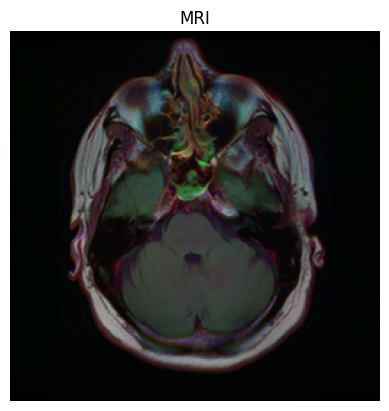

In [70]:
#HIDE
# @title MRI scan

%cd '/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Brain_MRI'
brain_df = pd.read_csv('data_mask.csv')
plt.imshow(cv2.imread(brain_df.image_path[624]))
plt.title("MRI")
plt.axis("off")

plt.show()

# Introduction to the Brain Tumor Detection

Deep learning has proven to be as good and even better than humans in detecting diseases from X-rays, MRI scans and CT scans. there is huge potential in using AI to speed up and improve the accuracy of diagnosis.
This project will use the labeled dataset from https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation which consists of 3929 Brain MRI scans and the tumor location.
The final pipeline has a two step process where
1. A **Resnet deep learning classifier model** will classify the input images into two groups: tumor detected and tumor not detected.
2. For the images, where tumor was detected, a second step is performed, where a **ResUNet segmentation model** detects the tumor location on the pixel level.


## Image segmentation

Image segmentation extracts information from images on the level of pixels. It is used for object recognition and localization in applications like medical imaging and self-driving cars. Image segmentation **produces a pixel-wise mask** of the image with deep learning approaches using common architectures such as CNN, FNNs and Deep Encoders-Decoders.

With Unet, the input and the output have the same size so the size of the images is preserved. In contrast to the CNN image classification, where the image is converted to a vector and the entire image is classified as a class label, the Unet performs classification on pixel level. Unet formulates a loss function for every pixel and then a softmax function is applied to every pixel. In other words, the segmentation problem is solved as a classification problem.

## Looking into the data

We have a csv file that contains the patient IDs, the locations of the images, their masks and indicator if there is a tumor in the image (1 - tumor, 0 - healthy). There are 1373 images with tumors and 2556 healthy brain images. Thus, the dataset is imbalanced.

In [64]:
#HIDE
# data containing path to Brain MRI and their corresponding mask

brain_df.info()
brain_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [8]:
brain_df.mask_path[1] # Path to the brain MRI image

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [9]:
brain_df.image_path[1] # Path to the segmentation mask

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [10]:
#HIDE
brain_df['mask'].value_counts()

,count
mask,
0,2556
1,1373


## Visualisation of the datasets

In [84]:
#HIDE
import plotly.io as pio
pio.renderers.default = "notebook_connected"
fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index,y=brain_df['mask'].value_counts()) ])

mask_counts = brain_df['mask'].value_counts()
colors = palette_hex[:len(mask_counts)]  # trim if more bars than colors

fig.update_traces(
    marker_color=colors,
    marker_line_color=colors,
    marker_line_width=2,
    opacity=0.6,
    width=0.5,
)

fig.update_layout(
    xaxis=dict(
        tickmode="array",
        tickvals=mask_counts.index,                # where ticks are
        ticktext=[str(v) for v in mask_counts.index],  # what labels show
        title="Mask value",
    ),
    yaxis_title="Count",
    title = "Healthy vs. Tumor images in dataset"
)
fig.show()

# IMPORTANT: create an actual HTML output that nbconvert will keep
display(HTML(fig.to_html(full_html=False, include_plotlyjs="cdn")))
# Save as an HTML file
#out_file = image_base / "mask_counts_plot.html"
#fig.write_html(str(out_file), include_plotlyjs="cdn", full_html=True)

Below is an exmaple of an MRI image and the matching mask. This example has a small tumor. In images where no tumor is present, the mask will be complety black.

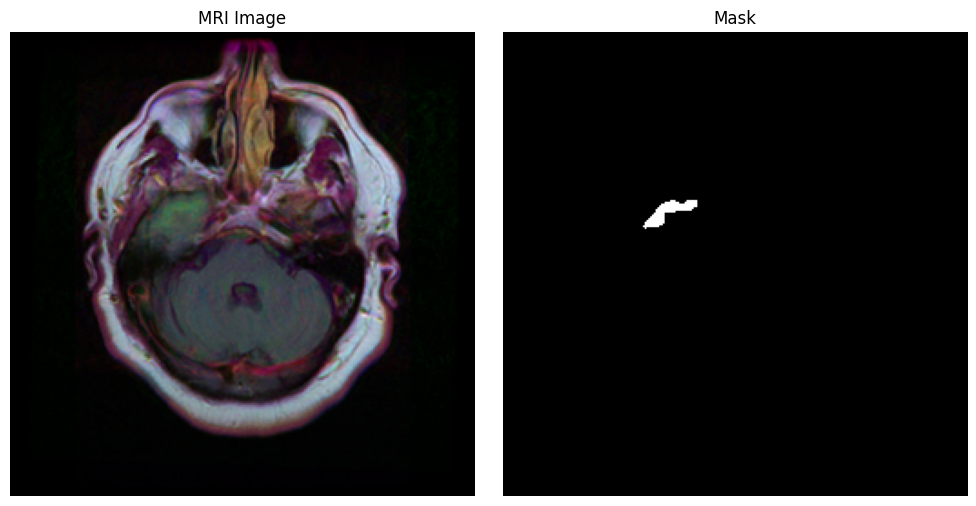

In [ ]:
#HIDE

mask = brain_df.mask_path[623]

img = brain_df.image_path[623]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(cv2.imread(img))
axes[0].set_title("MRI Image")
axes[0].axis("off")

axes[1].imshow(cv2.imread(mask), cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Below are visualisations from 6 MRIs and their overlayed masks in rose color.

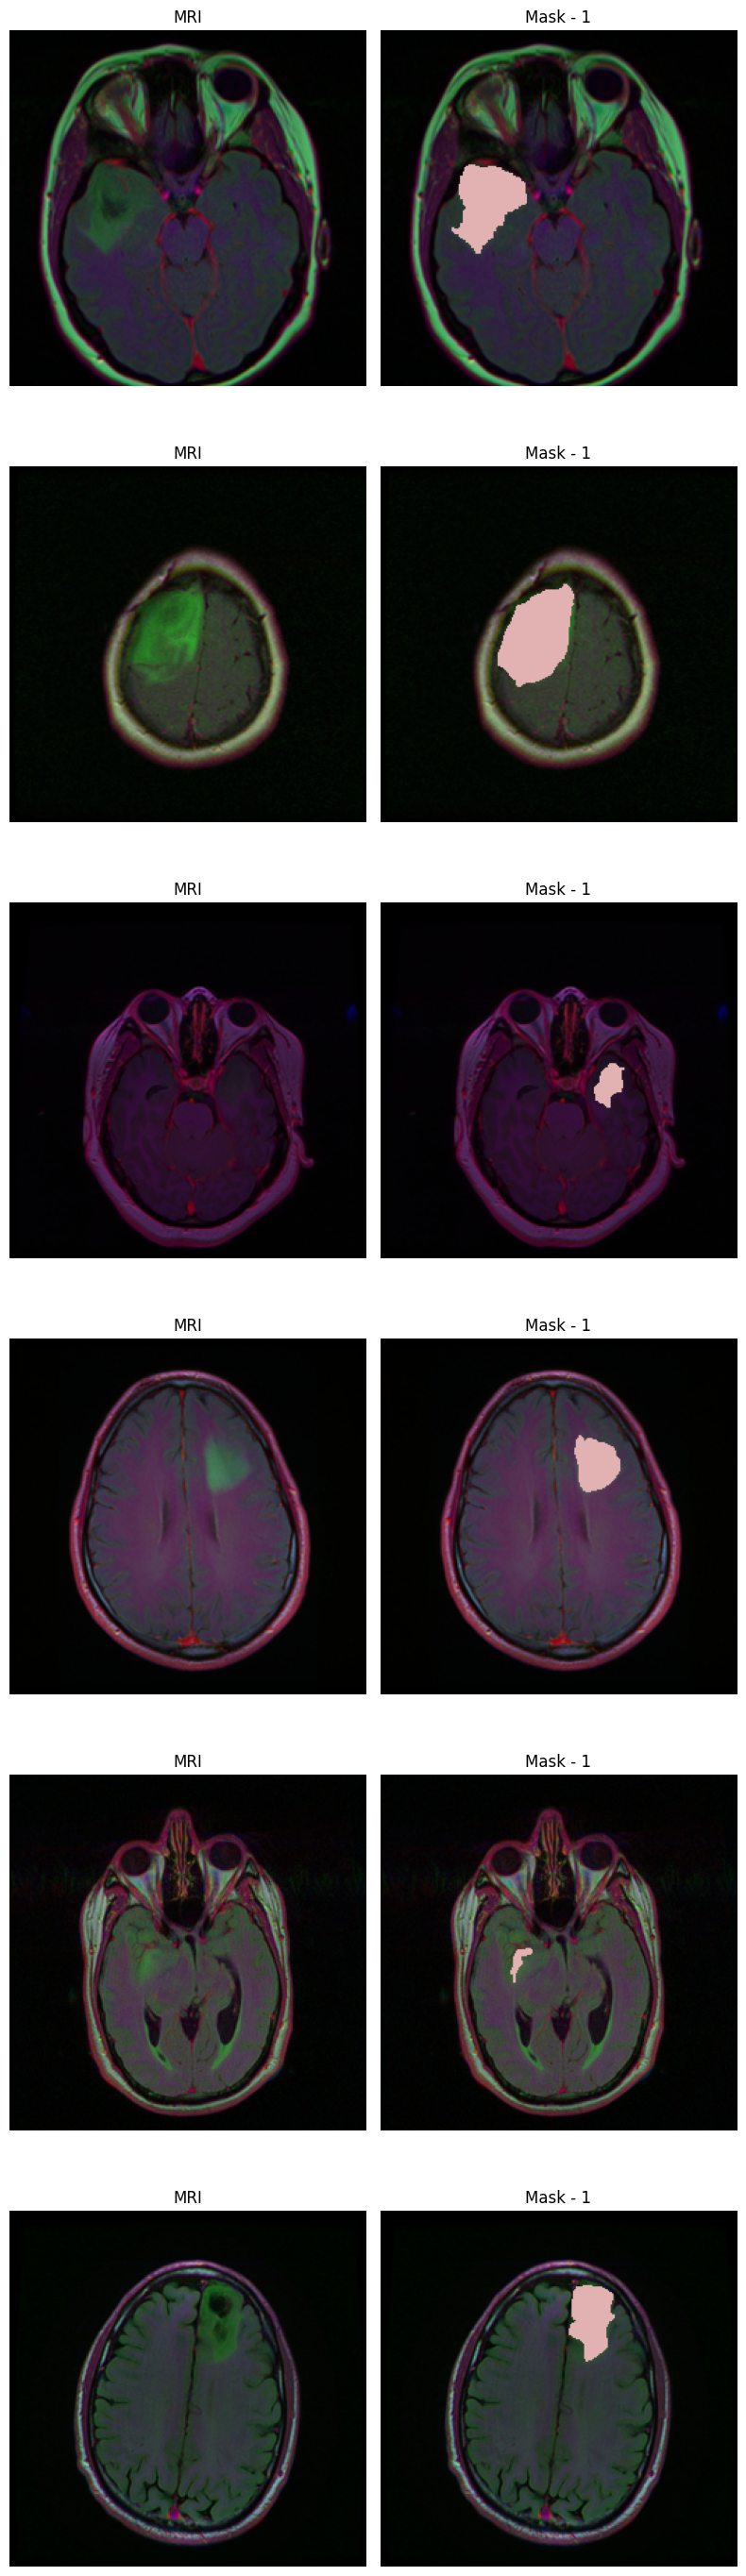

In [ ]:
#HIDE
def hex_to_rgb(hex_str):
    hex_str = hex_str.lstrip("#")
    return tuple(int(hex_str[i:i+2], 16) for i in (0, 2, 4))


brain_df_mask1 = brain_df[brain_df["mask"] == 1].reset_index(drop=True)

fig, axs = plt.subplots(6, 2, figsize=(8, 28))

for row in range(6):
  i = random.randint(0, len(brain_df_mask1))

  img = cv2.imread(brain_df_mask1.image_path[i])
  axs[row][0].title.set_text("MRI")
  axs[row][0].imshow(img)
  axs[row][0].axis("off")


  axs[row][1].title.set_text("MRI")
  axs[row][1].imshow(img)

  mask = cv2.imread(brain_df_mask1.mask_path[i],cv2.IMREAD_GRAYSCALE)

  # Overlay mask in blue with transparency
  img[mask == 255] = hex_to_rgb(palette['Rose'])
  axs[row][1].imshow(img)
  axs[row][1].title.set_text("Mask - " + str(brain_df_mask1['mask'][i]))
  axs[row][1].axis("off")
  count += 1

fig.tight_layout()

## Convolutional neural networks (CNNs)
- The first CNN layers are used to extract high level general features
- The last couple of layers will perform classification
- Locla respective fields scan the image first searching for simple shapes such as edges and lines
- The edges are picked up by the subsequent layer to form more complex features
Good visualisation of the feature extraction with convolutions can be found at https://setosa.io/ev/image-kernels/





## ResNet (Residual Network)
- As CNNs grow deeper, vanishing gradients negatively imapct the network performance. Vanishing gradient occurs when the gradient is backpropagated to earlier layers which results in a very small gradient.
- ResNets "skip connection" feature can allow training of 152 layers wihtout vanishing gradient problems
- ResNet adds "identity mapping on top of the CNN
- ResNet deep network is trained with ImageNet, which contains 11 million images and 11 000 categories

ResNet paper (He etal, 2015): https://arxiv.org/pdf/1512.03385

As seen in the Figure 6. from the Resnet paper, the ResNet architectures overcome the training challenges from deep networks compared ot the plain networks. ResNet-152 achieved 3.58% error rate on the ImageNet dataset. This is better than human performance.

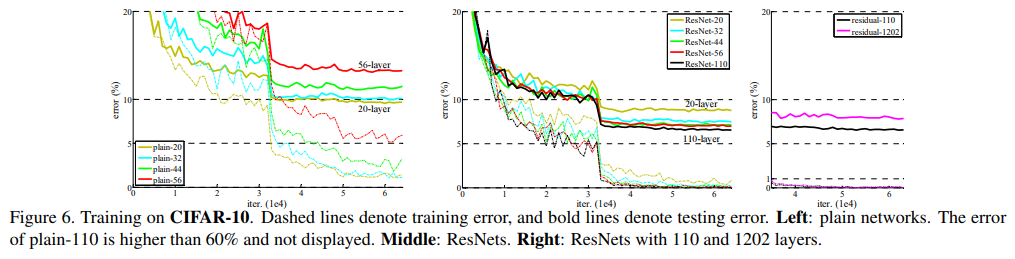

In [38]:
#HIDE
image_path = image_base / 'resnetwork.png'
display(Image(filename=image_path))

Siddarth Das has made agreat comparison of CNN architecture performances, you can check it out here: https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

## Transfer learning

Transfer learning retrains a network that has been trained to perform a specific task to use it in a similar task. The use of a pretrained model can drastically reduce the computational time and the amount of training data required, compared to starting from scratch. It can be compared to a salsa dancer starting to learn bachata; he/she will probably do a lot better than a person who has never danced before.

There are two main strategies in transfer learning:
1. **Freeze the trained CNN network weights from the first layers** and the train newly added dense layers. The new layers are initialized with random weights.
2. **Retrain the entire CNN network** while setting the learning rate to be very small. With too large learning rate the already trained weights might be changed too dramatically.

In this project I will use the approach 1.

Transfer learning has it's own challenges:
- **Negative Transfer**: the source task/domain is “close enough to look useful” but actually pushes the model in the wrong direction, hurting performance compared to training from scratch. This occurs when the features of old and new tasks are not related.
- **Which layers to transfer / freeze**: deciding what to reuse vs retrain is nontrivial; freezing too much can underfit, unfreezing too much can overfit or destabilize training.
- **Representation misalignment**: even if tasks are related, the internal features might not separate target classes well, especially when target cues differ (e.g., medical imaging vs natural images).
- **Transfer bounds**: Measuring the amount of knowledge transfered is crucial to ensure model quality and robustness. It is worth considering, how to quantify this, and it is a subject of ongoing research.


This is a great resource for transfer learning from Dipanjan Sarkar: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a/


# Part 1: Training a classifier model to detect if tumor exists or not

I use the flow_from_dataframe for training.
Batch size = 16
class mode = categorical

In [71]:
#HIDE
%%capture
# @title Train test split
#Drop the patient_id (we don't need it)
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.head(0)
brain_df_train.info()

#convert the data in mask column into a string format, to use categorical mode
#in flow_fom_dataframe. Otherwise we get TypeError
brain_df_train['mask'] = brain_df_train['mask'].astype(str)
brain_df_train.info()
train, test = train_test_split(brain_df_train, test_size=0.15)

In [72]:
#HIDE
# @title Image generator

#create a data generator which scales the data from 0 to 1 and makes validation
#dividing with 255 normalises the vaues which are between 0 and 255
#split of 0.15
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)



In [73]:
# @title Preparing image generators
train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'training',
    batch_size =16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256, 256)
)
valid_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'validation',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256, 256)
)
#create a data generator for test images
#no need for splitting again because here we use the "test" data set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_dataframe(
    dataframe = test,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256, 256)
)

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [6]:
# @title Retireve ResNet50 base model
#Input tensror 256 x 256 x 3
basemodel = ResNet50(weights = 'imagenet', include_top = False,
                     input_tensor = Input(shape = (256, 256, 3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Below is the architecture of the ResNet50 model. For the transfer learning, all of these layers will be set to trainable = False to stop the weights from changing.

In [59]:
#HIDE
# @title Helper function for plotting the architecture
!apt-get -qq install -y graphviz
!pip -q install pydot

import re
import subprocess
from pathlib import Path
from typing import Dict, Optional, Tuple, List

from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG, display

def export_colored_model_graph(
    model,
    image_base,
    stem: str = "model_arch",
    palette_hex: Optional[List[str]] = None,
    type_color_map: Optional[Dict[str, str]] = None,
    show_shapes: bool = True,
    show_layer_names: bool = True,
    rankdir: str = "TB",
    size: str = "30,18",
    nodesep: str = "0.15",
    ranksep: str = "0.25",
    splines: str = "polyline",
    edge_color: str = "#000000",
    node_border_color: str = "#202020",
    bg_color: str = "white",
    border_width: int = 1,
    display_svg: bool = True,
    return_mapping: bool = True,
) -> Tuple[Path, Path, Path, Optional[Dict[str, str]]]:
    """
    Exports a Keras model graph with colored nodes (stable by layer TYPE in parentheses).
    - Stable mapping: alphabetical layer types -> palette cycle (or use type_color_map to pin types).
    - Fixes Keras HTML labels by rewriting bgcolor/font only where needed.
    - Forces consistent border color via <table color="..."> (does NOT override font colors).
    - Forces all graph edges to edge_color.
    """

    if palette_hex is None:
        palette_hex = ["#8ecae6","#219ebc","#126782","#023047","#ffb703","#fd9e02","#fb8500"]

    out_dir = Path(image_base).resolve()
    out_dir.mkdir(parents=True, exist_ok=True)

    dot_path = out_dir / f"{stem}.dot"
    svg_path = out_dir / f"{stem}.svg"
    png_path = out_dir / f"{stem}.png"

    dot = model_to_dot(
        model,
        show_shapes=show_shapes,
        show_layer_names=show_layer_names,
        rankdir=rankdir,
        expand_nested=False,
    )

    dot.set_graph_defaults(
        splines=splines,
        outputorder="edgesfirst",
        concentrate="false",
        ranksep=ranksep,
        nodesep=nodesep,
        pad="0.2",
        margin="0.2",
        ratio="compress",
        size=size,
    )

    # Node border set here is mostly irrelevant (HTML label draws the box),
    # but doesn't hurt:
    dot.set_node_defaults(fontsize="8", margin="0.02", penwidth=str(max(1, border_width)))

    # Make ALL edges black (and enforce again below on each edge)
    dot.set_edge_defaults(arrowsize="0.4", penwidth="1.1", color=edge_color)

    # ---- helpers ----
    def hex_luma(h):
        h = h.lstrip("#")
        r, g, b = int(h[0:2], 16)/255, int(h[2:4], 16)/255, int(h[4:6], 16)/255
        return 0.2126*r + 0.7152*g + 0.0722*b

    def best_text_color(fill_hex):
        return "white" if hex_luma(fill_hex) < 0.55 else "black"

    # Keras label contains: "<b>layer_name</b> (LayerType)"
    rx = re.compile(r"<b>(?P<lname>[^<]+)</b>\s*\((?P<ltype>[^)]+)\)")

    # Collect all types present
    types_found = []
    for node in dot.get_nodes():
        lab = node.get("label")
        if not lab:
            continue
        m = rx.search(lab)
        if m:
            types_found.append(m.group("ltype"))
    types_found = sorted(set(types_found))

    # Stable mapping type->color
    if type_color_map is not None:
        type_to_color = dict(type_color_map)
        remaining = [t for t in types_found if t not in type_to_color]
        for i, t in enumerate(remaining):
            type_to_color[t] = palette_hex[i % len(palette_hex)]
    else:
        type_to_color = {t: palette_hex[i % len(palette_hex)] for i, t in enumerate(types_found)}

    def _fix_table_tag(table_tag: str) -> str:
        """Ensure the <table ...> has consistent border/grid color and border widths."""
        tag = table_tag

        # Force border + cellborder to be present and consistent
        if re.search(r'\bborder="', tag):
            tag = re.sub(r'\bborder="[^"]*"', f'border="{border_width}"', tag)
        else:
            tag = tag[:-1] + f' border="{border_width}">'

        if re.search(r'\bcellborder="', tag):
            tag = re.sub(r'\bcellborder="[^"]*"', f'cellborder="{border_width}"', tag)
        else:
            tag = tag[:-1] + f' cellborder="{border_width}">'

        # Force table border/grid color (THIS affects table lines, not text fonts)
        if re.search(r'\bcolor="', tag):
            tag = re.sub(r'\bcolor="[^"]*"', f'color="{node_border_color}"', tag)
        else:
            tag = tag[:-1] + f' color="{node_border_color}">'

        return tag

    def recolor_html_label(label: str, header_fill: str) -> str:
        """
        Rewrite Keras HTML label:
        - Replace ALL bgcolor="black" -> bgcolor=bg_color (so no leftover black fills)
        - Recolor ONLY the header cell background
        - Set ONLY the header font color for contrast
        - Force ONLY the table border/grid color (via <table color="...">)
        """
        # 1) Remove all black cell fills (Keras uses black by default)
        lab2 = label.replace('bgcolor="black"', f'bgcolor="{bg_color}"')

        # 2) Recolor header cell background (the td with colspan="2")
        lab2 = re.sub(
            r'(<td[^>]*colspan="2"[^>]*bgcolor=")([^"]*)(")',
            rf'\1{header_fill}\3',
            lab2,
            count=1
        )

        # 3) Set ONLY the header font color (first <font ... color="..."> is usually header)
        header_text = best_text_color(header_fill)
        lab2 = re.sub(
            r'(<font[^>]*color=")([^"]+)(")',
            rf'\1{header_text}\3',
            lab2,
            count=1
        )

        # 4) Force consistent table border/grid styling by editing only the <table ...> tag
        lab2 = re.sub(
            r"<table[^>]*>",
            lambda m: _fix_table_tag(m.group(0)),
            lab2,
            count=1
        )

        return lab2

    # Apply node label rewrites
    for node in dot.get_nodes():
        lab = node.get("label")
        if not lab:
            continue
        m = rx.search(lab)
        if not m:
            continue

        ltype = m.group("ltype")
        fill = type_to_color.get(ltype, palette_hex[0])

        node.set_style("filled,rounded")
        node.set_shape("box")
        node.set_color(node_border_color)  # outer node outline (if used)
        node.set_fontcolor(node_border_color)

        node.set("label", recolor_html_label(lab, fill))

    # Enforce all existing edges black as well
    for e in dot.get_edges():
        e.set_color(edge_color)

    # Write DOT
    dot_path.write_text(dot.to_string())

    # Render with cairo to avoid cropped SVG
    tmp_svg = out_dir / f"{stem}__tmp.svg"
    tmp_png = out_dir / f"{stem}__tmp.png"
    if tmp_svg.exists(): tmp_svg.unlink()
    if tmp_png.exists(): tmp_png.unlink()

    res = subprocess.run(["dot", "-Tsvg:cairo", str(dot_path), "-o", str(tmp_svg)],
                         capture_output=True, text=True)
    if res.returncode != 0:
        raise RuntimeError(f"Graphviz SVG render failed:\n{res.stderr}")

    subprocess.check_call(["dot", "-Tpng", str(dot_path), "-o", str(tmp_png)])

    tmp_svg.replace(svg_path)
    tmp_png.replace(png_path)

    if display_svg:
        display(SVG(data=svg_path.read_text()))

    return dot_path, svg_path, png_path, (type_to_color if return_mapping else None)



In [47]:
#HIDE
# -----------------------------
# Example usage
# -----------------------------
palette_hex_7 = ["#8ecae6","#219ebc","#126782","#023047","#ffb703","#fd9e02","#fb8500"]

dot_path, svg_path, png_path, type_to_color = export_colored_model_graph(
    model=basemodel,
    image_base=image_base,
    stem="model_arch",
    palette_hex=palette_hex_7,
    show_shapes=True,
    rankdir="TB",
    edge_color="#000000",
    bg_color="white",
    border_width=1,
    display_svg=True,
)

print("\nType->Color mapping used:")
for t in sorted(type_to_color.keys()):
    print(f"{t:25s} -> {type_to_color[t]}")

In [22]:
#HIDE
for layer in basemodel.layers:
  layers.trainable = False #set layers to a mode where they cannot be trained

In [31]:
# Add classification head to the base model
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4, 4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

fullmodel = Model(inputs = basemodel.input, outputs = headmodel)

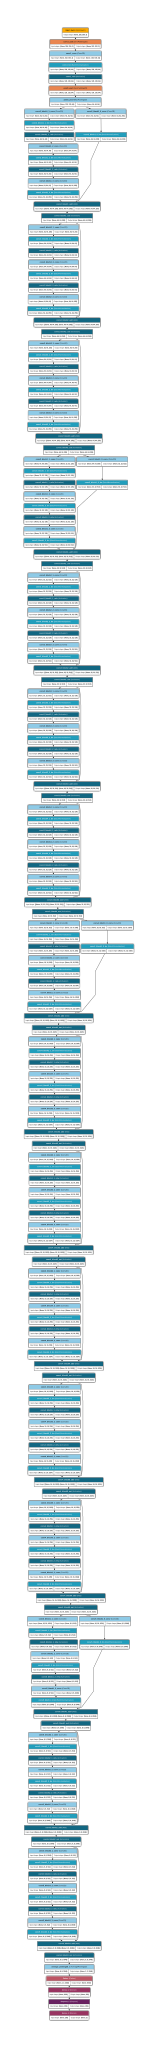

In [51]:
#HIDE
# -----------------------------
# Full model
# -----------------------------
dot_path, svg_path, png_path, type_to_color = export_colored_model_graph(
    model=fullmodel,
    image_base=image_base,
    stem="model_arch",
    type_color_map= {
    "InputLayer": "#ffaa00",
    "ZeroPadding2D":"#e9854f",
    "Conv2D": "#8ECAE6",
    "BatchNormalization": "#219EBC",
    "Activation": "#126782",
    "ReLU": "#993461",
    "Add": "#126782",
    "MaxPooling2D": "#8ecae6",
    "Flatten": "#bd5665",
    "Dense": "#993461",
    "Dropout": "#692161",
    },
    show_shapes=True,
    rankdir="TB",
    edge_color="#000000",
    bg_color="white",
    border_width=1,
    display_svg=True,
)

#print("\nType->Color mapping used:")
#for t in sorted(type_to_color.keys()):
#  print(f"{t:25s} -> {type_to_color[t]}")

In [74]:
# compile the model
fullmodel.compile(loss = 'categorical_crossentropy', optimizer='adam',
              metrics=["accuracy"])

In [75]:
# use the early stopping to exit training
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose = 1,
                              patience = 20)
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath='classifier-resnet-weights.keras',
                               verbose=1, save_best_only=True)

In [76]:
history = fullmodel.fit(train_generator,
            steps_per_epoch = train_generator.n // train_generator.batch_size,
            epochs=1,
            validation_data=valid_generator,
            validation_steps= valid_generator.n // valid_generator.batch_size,
            callbacks=[checkpointer, earlystopping])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6947 - loss: 1.1854 
Epoch 1: val_loss improved from inf to 0.68954, saving model to classifier-resnet-weights.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 3484s 19s/step - accuracy: 0.6949 - loss: 1.1833 - val_accuracy: 0.6552 - val_loss: 0.6895


In [79]:
#HIDE
model_json = fullmodel.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [88]:
#HIDE
push_git = True
# @title GIT commands
# Add changes
if push_git:
  !git add .

In [18]:
#HIDE
!git status -sb
!git add .gitignore

In [89]:
#HIDE
# Commit changes and remember to change commit message
if push_git:
  !git commit -m "Added theory and the model" #Remember to change commit message

[main 5709d19] Added theory and the model
 8 files changed, 44432 insertions(+), 207 deletions(-)
 create mode 100644 docs/pics/mask_counts_plot.html
 create mode 100644 docs/pics/model_arch.dot
 create mode 100644 docs/pics/model_arch.png
 create mode 100644 docs/pics/model_arch.svg
 create mode 100644 mask_counts_plot.html
 rewrite master.ipynb (61%)


In [90]:
#HIDE
# Push changes
if push_git:
  with open('/content/drive/MyDrive/tokens/token1.txt', 'r') as f:
      token = f.read().strip()

  !git push https://$token@github.com/KaisuH/brain-tumor-detector.git

Enumerating objects: 18, done.
Counting objects: 100% (18/18), done.
Delta compression using up to 2 threads
Compressing objects: 100% (12/12), done.
Writing objects: 100% (12/12), 4.05 MiB | 4.21 MiB/s, done.
Total 12 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), done.
To https://github.com/KaisuH/brain-tumor-detector.git
   9b26235..5709d19  main -> main


In [ ]:
#HIDE
#for removing the last line in gitignore
#!sed -i '$d' .gitignore
#for printing the gitignore
#!cat .gitignore

In [ ]:
#HIDE
make_new_branch = False
if make_new_branch:
  # 1. Create a brand-new “orphan” branch (no history)
  !git checkout --orphan clean-start

  # 2. Stage everything in your current working directory
  !git add -A

  # 3. Commit it as your one “fresh start” commit
  !git commit -m "Fresh start: keep only current work"

  # 4. Force-push this new branch to overwrite remote main
  !git push https://$token@github.com/KaisuH/Emotion-AI.git clean-start:main --force

  # 5. (Optional) Switch back to ‘main’ locally and delete the temp branch
  !git checkout main
  !git branch -D clean-start

In [96]:
#HIDE
# @title Producing the final file
%%capture

%cd '/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector'
import nbformat

nb_name = "master.ipynb"        # original notebook
out_nb_name = "master_tagged.ipynb"  # new notebook with tags

nb = nbformat.read(nb_name, as_version=4)

for cell in nb.cells:
    if cell.cell_type == 'code':
        # Check if the first line of the cell source is #HIDE
        first_line = cell.source.strip().split('\n',1)[0]
        if first_line.strip().startswith('#HIDE'):
            cell.metadata.setdefault('tags', []).append('hide_input')
nbformat.write(nb, out_nb_name)

In [97]:
#HIDE
%%capture
#Run this code to generate the tagged file
%%writefile hide_code_config.json
{
  "TagRemovePreprocessor": {
    "enabled": true,
    "remove_input_tags": ["hide_input"]
  },
  "Exporter": {
    "exclude_input_prompt": true,
    "exclude_output_prompt": true
  }
}

In [95]:
#HIDE
%%capture
# Run this line to produce the output
!jupyter nbconvert --to html --config hide_code_config.json \
    --output "docs/index.html" "master_tagged.ipynb"


### Renaming the document to produce a nicer name in web tab ###
# After nbconvert generates the HTML:
with open("docs/index.html", "r") as f:
    html_content = f.read()

# Find and replace the title tag content
new_title = "Brain tumor detector"  # Your desired title
html_content = html_content.replace("<title>master_tagged</title>", f"<title>{new_title}</title>")

# Insert CSS just before </head> to ensure it loads after default styles
style_snippet = """
<style>
/* Force horizontal scroll on wide code cells */
.jp-RenderedText pre,
.jp-RenderedHTMLCommon pre,
.jp-Cell .jp-Cell-inputWrapper .CodeMirror-lines,
.jp-Cell .jp-Cell-inputWrapper pre {
  white-space: pre !important;
  overflow-x: auto !important;
  max-width: 100% !important;
  display: block !important;
}

</style>
"""

# Insert style snippet at the end of <head>, or if you prefer, after <head>:
html_content = html_content.replace(
    "</head>",
    f"{style_snippet}\n</head>"
)

# Save the modified HTML
with open("docs/index.html", "w") as f:
    f.write(html_content)

In [ ]:
#HIDE
%%capture
# Run this line to produce the output
!jupyter nbconvert --to html --config hide_code_config.json \
    --output "docs/index.html" "master_tagged.ipynb"


### Renaming the document to produce a nicer name in web tab ###
# After nbconvert generates the HTML:
with open("docs/index.html", "r") as f:
    html_content = f.read()
import re
from pathlib import Path

# Paths (adjust if yours differ)
docs_dir = Path("docs")
css_dir  = docs_dir / "css"

bootstrap_css = "css/bootstrap.min.css"     # served from docs/css/bootstrap.min.css
navbar_file   = css_dir / "navbar.html"     # file on disk

# --- Read the generated HTML ---
with open(docs_dir / "index.html", "r", encoding="utf-8") as f:
    html_content = f.read()

# --- 1) Ensure bootstrap theme CSS is linked in <head> ---
bootstrap_link = f'<link rel="stylesheet" href="{bootstrap_css}">\n'
if bootstrap_link not in html_content:
    html_content = html_content.replace("</head>", bootstrap_link + "</head>", 1)

# --- 2) Load navbar.html and strip any <body>...</body> wrapper (your file contains one) ---
navbar_html = navbar_file.read_text(encoding="utf-8")

# remove <body> tags if present (prevents invalid nested body)
navbar_html = re.sub(r"</?body[^>]*>", "", navbar_html, flags=re.IGNORECASE).strip()

# Insert navbar right after opening <body ...>
html_content = re.sub(r"(<body[^>]*>)", r"\1\n" + navbar_html + "\n", html_content, count=1)

# --- 3) Your gradient / page styling (optional, matches your homepage look) ---
style_snippet = """
<style>
body{
  background: linear-gradient(360deg, #3a3f44, #272b30, #1b1f24);
  background-size: cover;
  background-attachment: fixed;
}
</style>
"""
html_content = html_content.replace("</head>", style_snippet + "\n</head>", 1)

# --- 4) (Optional) Fix title ---
new_title = "Brain tumor detector"
html_content = re.sub(r"<title>.*?</title>", f"<title>{new_title}</title>", html_content, count=1)

# --- Write back ---
with open(docs_dir / "index.html", "w", encoding="utf-8") as f:
    f.write(html_content)

print("Updated docs/index.html with Bootstrap + navbar.")

# Find and replace the title tag content
new_title = "Brain tumor detector"  # Your desired title
html_content = html_content.replace("<title>master_tagged</title>", f"<title>{new_title}</title>")

# Insert CSS just before </head> to ensure it loads after default styles
style_snippet = """
<style>
/* Force horizontal scroll on wide code cells */
.jp-RenderedText pre,
.jp-RenderedHTMLCommon pre,
.jp-Cell .jp-Cell-inputWrapper .CodeMirror-lines,
.jp-Cell .jp-Cell-inputWrapper pre {
  white-space: pre !important;
  overflow-x: auto !important;
  max-width: 100% !important;
  display: block !important;
}

</style>
"""

# Insert style snippet at the end of <head>, or if you prefer, after <head>:
html_content = html_content.replace(
    "</head>",
    f"{style_snippet}\n</head>"
)

# Save the modified HTML
with open("docs/index.html", "w") as f:
    f.write(html_content)